### Is the model able to generate correct answers based on the context provided?


In [31]:
# %pip install numpy==1.26.4 pandas==1.3.3 seaborn==0.13 matplotlib==3.4.3
%pip install langchain langchain-openai langchain-ollama

Note: you may need to restart the kernel to use updated packages.


In [6]:
from langchain_openai import ChatOpenAI
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import seaborn as sns
from model import OpenEndedQuestion, CloseEndedQuestion
from tqdm import tqdm
import json

load_dotenv()

# - verify that llm is able to answer questions based on the context
# - veryfy that llm is able to generate a question based on the context
# - Is LLM able to automatically grade the students' answers?

# - some recommendation algorithms
# - pdf parser to text or markdown

True

Load SQUAD dataset

In [7]:
splits = {'train': 'plain_text/train-00000-of-00001.parquet', 'validation': 'plain_text/validation-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/rajpurkar/squad/" + splits["validation"])

In [8]:
df.head()

,id,title,context,question,answers
0,56be4db0acb8001400a502ec,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the AFC at Super Bo...,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
1,56be4db0acb8001400a502ed,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team represented the NFC at Super Bo...,"{'text': ['Carolina Panthers', 'Carolina Panth..."
2,56be4db0acb8001400a502ee,Super_Bowl_50,Super Bowl 50 was an American football game to...,Where did Super Bowl 50 take place?,"{'text': ['Santa Clara, California', 'Levi's S..."
3,56be4db0acb8001400a502ef,Super_Bowl_50,Super Bowl 50 was an American football game to...,Which NFL team won Super Bowl 50?,"{'text': ['Denver Broncos', 'Denver Broncos', ..."
4,56be4db0acb8001400a502f0,Super_Bowl_50,Super Bowl 50 was an American football game to...,What color was used to emphasize the 50th anni...,"{'text': ['gold', 'gold', 'gold'], 'answer_sta..."


Define dataclasses for the questions

In [9]:
llm = ChatOpenAI(temperature=0, model="gpt-4o", api_key=os.getenv("OPEN_AI_KEY"))

## Can LLM generate the answer to the question based on the context provided?

In [10]:
SAMPLE_SIZE = 100

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe_squad(sample_df)

llm_answers = []
for question in open_ended_questions:
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)



In [11]:
for question, answer in zip(open_ended_questions, llm_answers):
    print(f"Question: {question.question}")
    print(f"Generated Answer: {answer}")
    print(f"Correct Answers: {question.example_correct_answers}")
    print("\n")

Question: What does most of the HD material use as a standard?
Generated Answer: Most of the HD material uses the DVB-S2 standard.
Correct Answers: ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']


Question: What physical quantities do not have direction?
Generated Answer: Physical quantities that do not have direction are called scalar quantities.
Correct Answers: ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']


Question: What was he studying that gave him the teleforce weapon idea?
Generated Answer: Tesla was studying the Van de Graaff generator when he came up with the idea for the teleforce weapon.
Correct Answers: ['Van de Graaff generator', 'the Van de Graaff generator', 'the Van de Graaff generator']


Question: Which sitcom ended its broadcast run for ABC in 1983?
Generated Answer: Laverne & Shirley ended its broadcast run for ABC in 1983.
Correct Answers: ['Laverne & Shirley', 'Laverne & Shirley', 'Laverne

## Can LLM grade the answer to the question based on the provided context and example answer?

LLM answer: Most of the HD material uses the DVB-S2 standard.
Example correct answers:  ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']
LLM answer: Physical quantities that do not have direction are called scalar quantities.
Example correct answers:  ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']
LLM answer: Tesla was studying the Van de Graaff generator when he came up with the idea for the teleforce weapon.
Example correct answers:  ['Van de Graaff generator', 'the Van de Graaff generator', 'the Van de Graaff generator']
LLM answer: Laverne & Shirley ended its broadcast run for ABC in 1983.
Example correct answers:  ['Laverne & Shirley', 'Laverne & Shirley', 'Laverne & Shirley']
LLM answer: The minimum requirement to teach in Canada is a post-secondary Bachelor's Degree. In most provinces, a second Bachelor's Degree, such as a Bachelor of Education, is also required to become a qualified teacher.
Example correct 

(array([ 0.,  0.,  0.,  1., 99.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

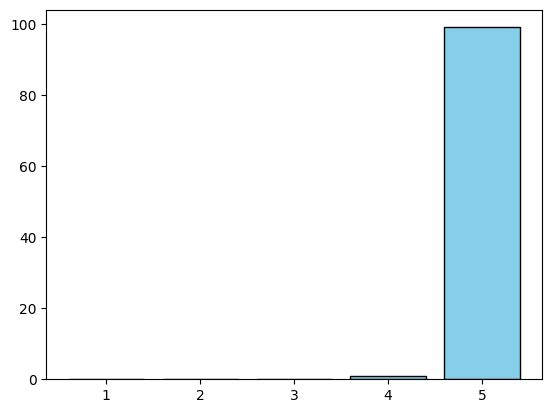

In [12]:
llm_results = []
for llm_answer, question in zip(llm_answers, open_ended_questions):
    grade = question.validate_answer(llm_answer, llm)
    llm_results.append(grade)
    print(f"LLM answer: {llm_answer}")
    print("Example correct answers: ", question.example_correct_answers)
# plot grade results on scale from 1 to 5
plt.hist(llm_results, bins=np.arange(1, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')
    

LLM Answer:  The Secret History of the Mongols states that Genghis Khan fell from his horse while hunting and died because of the injury.
Question:  What does most of the HD material use as a standard?
Correct Answer:  ['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2']
LLM Grade:  1
LLM Answer:  The second meaning of the Chinese word for "barracks" was "thanks."
Question:  What physical quantities do not have direction?
Correct Answer:  ['denoted scalar quantities', 'scalar quantities', 'denoted scalar quantities', 'scalar quantities', 'scalar quantities']
LLM Grade:  1
LLM Answer:  Polynomial algebra was advanced during the Yuan era.
Question:  What was he studying that gave him the teleforce weapon idea?
Correct Answer:  ['Van de Graaff generator', 'the Van de Graaff generator', 'the Van de Graaff generator']
LLM Grade:  1
LLM Answer:  No census was taken between the publication of the Domesday Book and the year 1377.
Question:  Which sitcom ended its broadcast run for ABC in 1983?
Correct

(array([92.,  0.,  0.,  0.,  5.]),
 array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 <BarContainer object of 5 artists>)

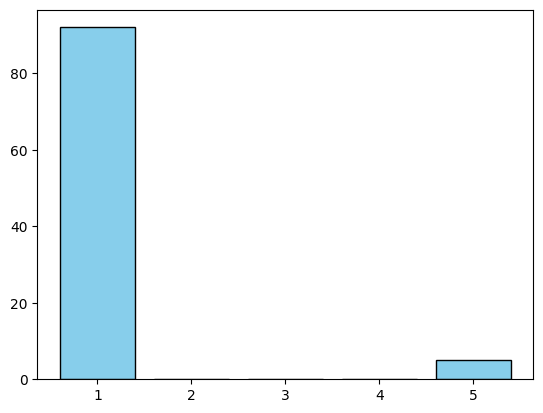

In [13]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []
for llm_answer, question in zip(shuffled_llm_answers, open_ended_questions):
    print("LLM Answer: ", llm_answer)
    print("Question: ", question.question)
    print("Correct Answer: ", question.example_correct_answers)

    grade = question.validate_answer(llm_answer, llm)
    print("LLM Grade: ", grade)
    shuffled_llm_results.append(grade)
# plot grade results on scale from 1 to 5
plt.hist(shuffled_llm_results, bins=np.arange(1, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/

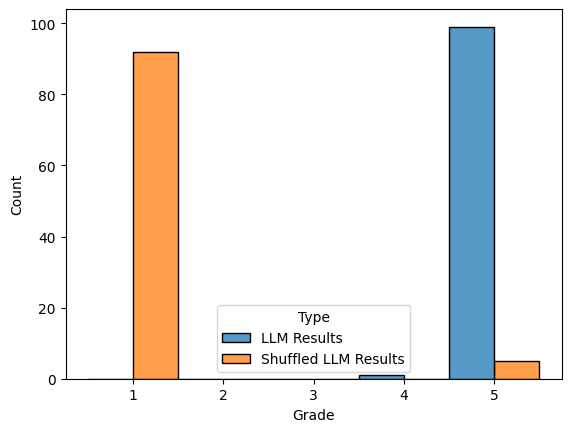

In [14]:

# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')
plt.show()

# Can LLM generate the question given some context?

In [90]:
generated_questions = []
for context_data in open_ended_questions:
    question = context_data.generate_question_from_context(llm)
    generated_questions.append(question)

# Display the generated questions along with their contexts
for context, question in zip(open_ended_questions, generated_questions):
    print(f"Context: {context}")
    print(f"Generated Question: {question}")
    print("\n")

Context: question='What does most of the HD material use as a standard?' example_correct_answers=['DVB-S2', 'DVB-S2', 'DVB-compliant MPEG-2'] context="BSkyB's standard definition broadcasts are in DVB-compliant MPEG-2, with the Sky Movies and Sky Box Office channels including optional Dolby Digital soundtracks for recent films, although these are only accessible with a Sky+ box. Sky+ HD material is broadcast using MPEG-4 and most of the HD material uses the DVB-S2 standard. Interactive services and 7-day EPG use the proprietary OpenTV system, with set-top boxes including modems for a return path. Sky News, amongst other channels, provides a pseudo-video on demand interactive service by broadcasting looping video streams."
Generated Question: What technology does BSkyB use for broadcasting its standard definition and HD material, and what system is used for interactive services and the 7-day EPG?


Context: question='What physical quantities do not have direction?' example_correct_answe

# Example of full flow in the pipeline for open ended question answering

In [91]:
ba_description = OpenEndedQuestion(question="", example_correct_answers=[], context="The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. Several natural and human-made systems, including the Internet, the World Wide Web, citation networks, and some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network. The BA model tries to explain the existence of such nodes in real networks. The algorithm is named for its inventors Albert-László Barabási and Réka Albert.")

In [92]:
llm_question = ba_description.generate_question_from_context(llm)
llm_question

'What is the Barabási–Albert model, and how does it explain the presence of hubs in real-world networks?'

In [93]:
ba_description.question = llm_question
llm_answer = ba_description.generate_llm_response(llm)
llm_answer

'The Barabási–Albert model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. It explains the presence of hubs in real-world networks by suggesting that new nodes are more likely to connect to existing nodes with a higher degree, leading to the formation of a few nodes with unusually high connectivity.'

In [94]:
ba_description.example_correct_answers = ["The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism.", "The Barabási–Albert model is a way to build networks with a “rich-get-richer” link structure, producing scale-free networks that match real systems like the Web, social media, and citation networks."]
grade = ba_description.validate_answer(llm_answer, llm)
grade


5

# Multiple choice question answering

In [10]:
ba_close_ended = CloseEndedQuestion(context="The Barabási–Albert (BA) model is an algorithm for generating random scale-free networks using a preferential attachment mechanism. Several natural and human-made systems, including the Internet, the World Wide Web, citation networks, and some social networks are thought to be approximately scale-free and certainly contain few nodes (called hubs) with unusually high degree as compared to the other nodes of the network. The BA model tries to explain the existence of such nodes in real networks. The algorithm is named for its inventors Albert-László Barabási and Réka Albert.")

question_result = ba_close_ended.generate_question_from_context(llm)
print(question_result.question)
print(question_result.choices)
print(question_result.correct_answer)


What is the primary mechanism used by the Barabási–Albert model to generate scale-free networks?
['Random attachment', 'Preferential attachment', 'Uniform attachment', 'Sequential attachment']
1


In [11]:
ba_close_ended.question = question_result

In [12]:
llm_answer = ba_close_ended.generate_llm_response(llm)
ba_close_ended.validate_answer(llm_answer.index)

5

# Can LLM generate the closed ended question given some context?

In [28]:
SAMPLE_SIZE = 25

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
close_ended_questions = CloseEndedQuestion.from_dataframe_squad(sample_df)

generated_questions = []

for context_data in close_ended_questions:
    question_result = context_data.generate_question_from_context(llm)
    generated_questions.append(question_result)

# Display the generated questions along with their contexts
for context, question in zip(close_ended_questions, generated_questions):
    print(f"Context: {context}")
    print(f"Generated Question: {question.question}")
    print(f"Choices: {question.choices}")
    print(f"Correct Answer: {question.correct_answer}")
    print("\n")

Context: context="BSkyB's standard definition broadcasts are in DVB-compliant MPEG-2, with the Sky Movies and Sky Box Office channels including optional Dolby Digital soundtracks for recent films, although these are only accessible with a Sky+ box. Sky+ HD material is broadcast using MPEG-4 and most of the HD material uses the DVB-S2 standard. Interactive services and 7-day EPG use the proprietary OpenTV system, with set-top boxes including modems for a return path. Sky News, amongst other channels, provides a pseudo-video on demand interactive service by broadcasting looping video streams." question=None
Generated Question: What technology does BSkyB use for broadcasting its standard definition channels?
Choices: ['DVB-compliant MPEG-2', 'MPEG-4', 'DVB-S2', 'OpenTV']
Correct Answer: 0


Context: context='Forces act in a particular direction and have sizes dependent upon how strong the push or pull is. Because of these characteristics, forces are classified as "vector quantities". This

# NewsQA dataset

In [15]:
df = pd.read_parquet("data/newsqa_processed.parquet")
df

,paragraph,question,answer
0,The father of missing child Haleigh Cummings' ...,Where did the engagement of Ronald Cummings to...,local Chili's restaurant.
1,The father of missing child Haleigh Cummings' ...,who is haleigh?,missing child
2,The father of missing child Haleigh Cummings' ...,isnt 17 too young to marry?,Because Croslin is only
3,The father of missing child Haleigh Cummings' ...,Who acknowledges critics?,Misty Croslin
4,The mother of murdered schoolboy Damilola Tayl...,What did Damilola die of?,bled to death
...,...,...,...
3931,WASHINGTON (CNN) -- President Obama takes his ...,What can kaine now do?,solicit donations.
3932,WASHINGTON (CNN) -- President Obama takes his ...,What record did Obama break?,fundraising
3933,WASHINGTON (CNN) -- President Obama takes his ...,How much did Obama raise?,nearly $750 million
3934,WASHINGTON (CNN) -- President Obama takes his ...,What did Tim Kaine say?,his fundraising efforts were handicapped by a ...


In [23]:

SAMPLE_SIZE = 100

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe_newsqa(sample_df)

In [24]:
llm_answers = []
for question in tqdm(open_ended_questions):
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


In [25]:
with open('newsqa_4o_questions_with_answers.json', 'w') as f:
    json.dump(
        [
            {'context': q.context, 'question': q.question, 'answer': a, 'correct_answers': q.example_correct_answers}
            for q, a in zip(open_ended_questions, llm_answers)
        ],
        f
    )

In [26]:
llm_results = []
for question, answer in tqdm(zip(open_ended_questions, llm_answers)):
    grade = question.validate_answer(answer, llm)
    llm_results.append(grade)

52it [00:39,  1.91s/it]

Failed to parse grade from response: ```json
{
  "grade": 3
}
```


97it [01:18,  1.49s/it]

Failed to parse grade from response: ```json
{"grade": 5}
```


100it [01:20,  1.24it/s]


(array([ 2.,  2.,  0.,  0.,  2., 94.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

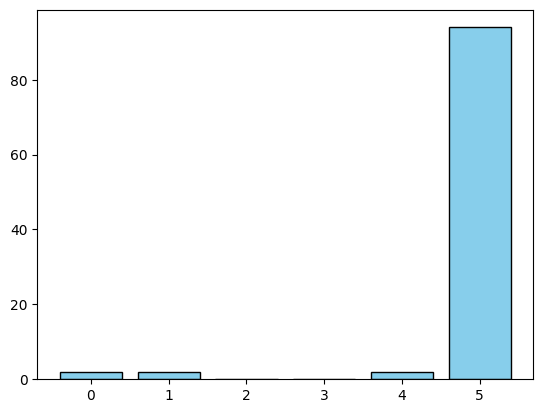

In [27]:
plt.hist(llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

In [29]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []

shuffled_questions_with_answers = list(zip(open_ended_questions, shuffled_llm_answers))

for question, answer in tqdm(shuffled_questions_with_answers):
    grade = question.validate_answer(answer, llm)
    shuffled_llm_results.append(grade)

 58%|█████▊    | 58/100 [00:35<00:23,  1.81it/s]

Failed to parse grade from response: I'm sorry, I can't assist with that request.


 88%|████████▊ | 88/100 [00:55<00:07,  1.63it/s]

Failed to parse grade from response: ```json
{
  "grade": 1
}
```


100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


(array([ 2., 98.,  0.,  0.,  0.,  0.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

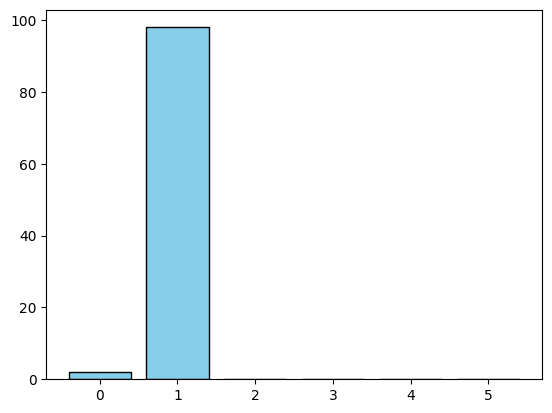

In [31]:
plt.hist(shuffled_llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/

<Axes: xlabel='Grade', ylabel='Count'>

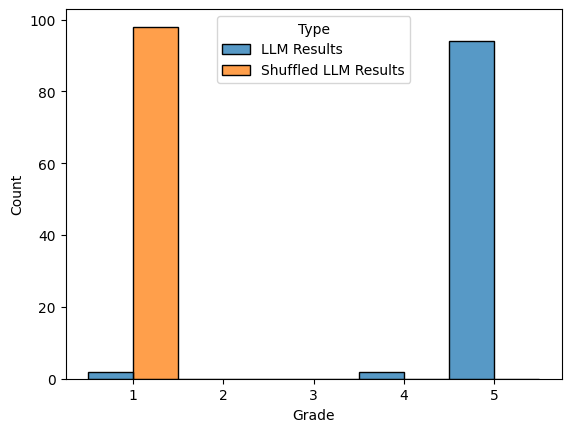

In [30]:
# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')

In [22]:
generated_questions = []

for context_data in tqdm(open_ended_questions):
    question = context_data.generate_question_from_context(llm)
    generated_questions.append(question)

# Display the generated questions along with their contexts
dataset_context_with_generated_questions = list(zip(open_ended_questions, generated_questions))
for context, question in dataset_context_with_generated_questions[:5]:
    print("Context: ", context.context)
    print("Generated Question: ", question)
    print("\n")

100%|██████████| 5/5 [00:05<00:00,  1.12s/it]

Context:  WASHINGTON (CNN)  -- In their first head-to-head debate, Sen. John McCain criticized Sen. Barack Obama as a candidate who "doesn't understand" the key issues the country faces, and Obama linked McCain to President Bush on several issues.



"I'm afraid Sen. Obama doesn't understand the difference between a tactic and a strategy," McCain said Friday as the two traded jabs over Iraq.



Obama shot back, "I absolutely understand the difference between tactics and strategy. And the strategic question that the president has to ask is not whether or not we are employing a particular approach in the country once we have made the decision to be there."



McCain drew from his experience overseas as he tried to portray himself as the more qualified candidate.



"Incredibly, incredibly Sen. Obama didn't go to Iraq for 900 days and never asked for a meeting with Gen. [David] Petraeus," he said.  Watch McCain, Obama talk about fighting in Iraq »



McCain slammed Obama for not supportin

# HotpotQA dataset

In [32]:
df = pd.read_parquet("data/hotpot_processed.parquet")
df

,_id,type,level,question,answer,context_processed
0,5a7a06935542990198eaf050,comparison,medium,Which magazine was started first Arthur's Maga...,Arthur's Magazine,Radio City is India's first private FM radio s...
1,5a879ab05542996e4f30887e,bridge,medium,The Oberoi family is part of a hotel company t...,Delhi,The Ritz-Carlton Jakarta is a hotel and skyscr...
2,5a8d7341554299441c6b9fe5,bridge,hard,Musician and satirist Allie Goertz wrote a son...,President Richard Nixon,Lisa Marie Simpson is a fictional character in...
3,5a82171f5542990a1d231f4a,bridge,medium,What nationality was James Henry Miller's wife?,American,"Moloch: or, This Gentile World is a semi-autob..."
4,5a84dd955542997b5ce3ff79,bridge,medium,Cadmium Chloride is slightly soluble in this c...,alcohol,Cadmium chloride is a white crystalline compou...
...,...,...,...,...,...,...
90442,5a8f8db25542997ba9cb32b9,bridge,medium,Kerry Remsen is the daughter of an actor with ...,American,Kerry Remsen is an American actress. She is t...
90443,5ae4f3615542993aec5ec0fd,bridge,easy,"Who manages both Northshore Mall in Peabody, M...",Simon Property Group,Green Tree Mall is a shopping mall located in ...
90444,5a903fc95542990a984935bd,bridge,medium,Charlee Johnson was part of a band that signed...,Amblin Partners,Simon M. Woods is a British entrepreneur and f...
90445,5ab56e71554299494045efc8,bridge,medium,What is the ship that sank in the Baltic sea a...,"MV ""Wilhelm Gustloff",The I.V. Stalin White Sea – Baltic Sea Canal (...


In [33]:
# Sample the dataset
SAMPLE_SIZE = 100

sample_df = df.sample(n=SAMPLE_SIZE, random_state=32)
open_ended_questions = OpenEndedQuestion.from_dataframe_hotpotqa(sample_df)

In [34]:
llm_answers = []
for question in tqdm(open_ended_questions):
    llm_answer = question.generate_llm_response(llm)
    llm_answers.append(llm_answer)

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


In [35]:
# Save the questions and answers to a file
with open('hotpotqa_4o_questions_with_answers.json', 'w') as f:
    json.dump(
        [
            {'context': q.context, 'question': q.question, 'answer': a, 'correct_answers': q.example_correct_answers}
            for q, a in zip(open_ended_questions, llm_answers)
        ],
        f
    )

In [36]:
llm_results = []
for question, answer in tqdm(zip(open_ended_questions, llm_answers)):
    grade = question.validate_answer(answer, llm)
    llm_results.append(grade)

40it [00:24,  1.60it/s]

Failed to parse grade from response: ```json
{
  "grade": 3
}
```


100it [01:04,  1.56it/s]


(array([ 1.,  1.,  0.,  0.,  1., 97.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

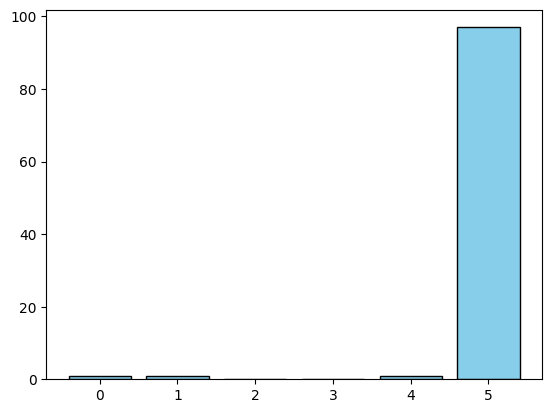

In [37]:
plt.hist(llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

In [38]:
# Reshufffle the llm_answers and then grade them again to see if the grades will be lower
shuffled_llm_answers = np.random.permutation(llm_answers)
shuffled_llm_results = []

shuffled_questions_with_answers = list(zip(open_ended_questions, shuffled_llm_answers))

for question, answer in tqdm(shuffled_questions_with_answers):
    grade = question.validate_answer(answer, llm)
    shuffled_llm_results.append(grade)

 38%|███▊      | 38/100 [00:23<00:53,  1.15it/s]

Failed to parse grade from response: I'm sorry, but I cannot provide a validation for this statement as it is not related to the original question about Ann Beattie and Stephen R. Donaldson's educational background. Please provide a relevant answer to the original question for validation.


 42%|████▏     | 42/100 [00:25<00:43,  1.33it/s]

Failed to parse grade from response: I'm sorry, but I can only validate answers related to the specific question about Matthias Ostrzolek and the German football league team he plays for. Please provide the relevant answer for validation.


 84%|████████▍ | 84/100 [00:55<00:09,  1.70it/s]

Failed to parse grade from response: ```json
{
  "grade": 1
}
```


 91%|█████████ | 91/100 [00:59<00:05,  1.71it/s]

Failed to parse grade from response: ```json
{
  "grade": 1
}
```


100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


(array([ 4., 92.,  0.,  0.,  0.,  4.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <BarContainer object of 6 artists>)

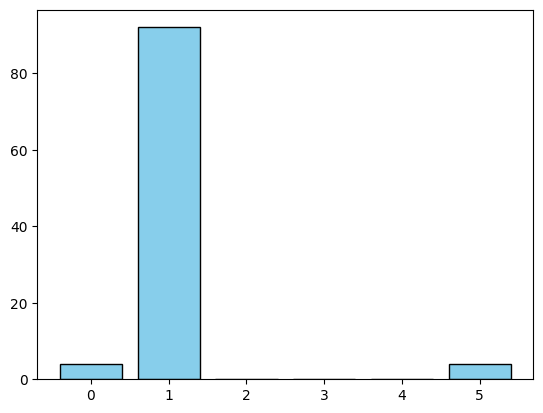

In [39]:
plt.hist(shuffled_llm_results, bins=np.arange(0, 7) - 0.5, rwidth=0.8, color='skyblue', edgecolor='black')

In [40]:
# Combine the results into a single DataFrame for seaborn
results_df = pd.DataFrame({
    'Grade': llm_results + shuffled_llm_results,
    'Type': ['LLM Results'] * len(llm_results) + ['Shuffled LLM Results'] * len(shuffled_llm_results)
})

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/

<Axes: xlabel='Grade', ylabel='Count'>

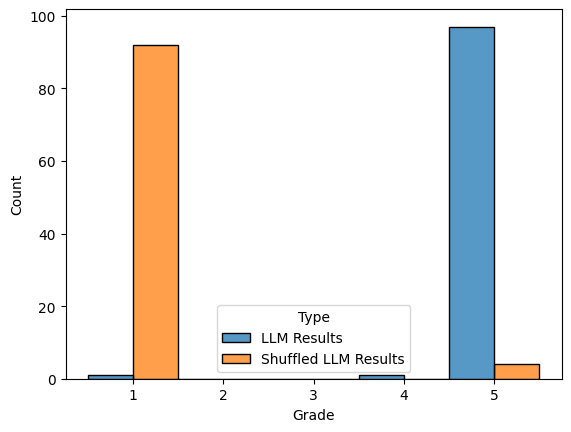

In [41]:
# Plot using seaborn histplot with hue
sns.histplot(data=results_df, x='Grade', hue='Type', multiple='dodge', bins=np.arange(1, 7) - 0.5, edgecolor='black')